In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math


In [76]:
train_data_raw =  pd.read_csv("Gasleak Data Sets/sensor_readings.csv")
train_data_raw.columns = ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [77]:
test_data_raw = pd.read_csv("Gasleak Data Sets/validation_files/sensor_readings.csv")
test_data_raw.columns =  ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [78]:
leak_data_raw = pd.concat([train_data_raw, test_data_raw], ignore_index=True)
leak_data = leak_data_raw.copy()
leak_data = leak_data.iloc[3000:7000]
leak_data = leak_data.drop(['temp'], axis=1)
leak_data['Sum'] = leak_data.iloc[:,1:].sum(axis=1)
leak_data['Mean'] = leak_data.iloc[:,1:-1].mean(axis=1)

In [79]:
leak_data

,Time,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Sum,Mean
3000,1681779003,1012.916667,1031.208333,1295.68,1034.28,968.000000,1132.0,1082.500000,1128.0,1147.000000,...,1257.0,1138.0,950.5,1186.0,1054.5,1136.0,1015.0,1070.000000,26024.585000,1084.357708
3001,1681779004,1013.500000,1029.750000,1301.72,1034.24,955.500000,1126.0,1082.000000,1110.0,1137.000000,...,1253.0,1138.0,949.0,1191.0,1057.0,1188.0,1020.5,1076.000000,25994.210000,1083.092083
3002,1681779005,1014.083333,1028.291667,1307.76,1034.20,943.000000,1115.5,1052.000000,1095.0,1133.000000,...,1249.0,1145.0,942.5,1189.0,1085.0,1185.0,1026.0,1073.000000,25929.335000,1080.388958
3003,1681779006,1014.666667,1026.833333,1313.80,1034.16,956.000000,1105.0,1054.000000,1084.0,1135.000000,...,1246.0,1145.0,936.0,1189.5,1084.0,1184.0,1092.0,1070.000000,25982.960000,1082.623333
3004,1681779007,1015.250000,1025.375000,1319.84,1034.12,953.666667,1111.0,1056.000000,1073.0,1137.000000,...,1250.0,1145.0,940.0,1190.0,1083.0,1183.0,1052.5,1082.000000,25995.751667,1083.156319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,1681783085,957.500000,978.000000,1145.00,1018.00,929.000000,1026.0,1004.500000,1185.0,1068.602941,...,1122.0,1009.0,893.0,1111.0,1047.0,1106.0,1040.0,1168.000000,24778.269608,1032.427900
6996,1681783086,969.000000,984.000000,1149.00,1022.00,929.000000,1023.5,1003.000000,1204.0,1068.539216,...,1129.0,1011.0,893.0,1110.0,1046.0,1116.0,1008.0,1186.000000,24833.539216,1034.730801
6997,1681783087,971.000000,983.000000,1153.00,1019.00,933.000000,1021.0,1004.000000,1210.5,1068.475490,...,1156.0,1004.5,891.0,1109.0,1048.0,1115.5,993.0,1204.000000,24904.975490,1037.707312
6998,1681783088,979.000000,980.500000,1130.00,1016.00,937.500000,1033.0,1006.333333,1217.0,1068.411765,...,1149.5,998.0,889.0,1122.0,1042.5,1115.0,995.0,1261.000000,24944.745098,1039.364379


In [80]:
def MinMax(X, col):
    return (X - col.min()) / (col.max() - col.min())
def invMinMax(X_scaled, col):
    X = X_scaled * (col.max() - col.min()) + col.min()
    return X

In [81]:
leak_data['Normalized Sensor 1'] = MinMax(leak_data['Sensor 1'], leak_data['Sensor 1'])

In [82]:
def load_data(feature, look_back):
    data_raw = feature.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
feature =  leak_data[['Normalized Sensor 1']]


x_train, y_train, x_test, y_test = load_data(feature, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3152, 59, 1)
y_train.shape =  (3152, 1)
x_test.shape =  (788, 59, 1)
y_test.shape =  (788, 1)


In [83]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [84]:
import model as m

input_dim = 1
hidden_dim = 16
num_layers = 2 
output_dim = 1

model = m.LSTM(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)

# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
10
torch.Size([64, 1])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([1, 16])
torch.Size([1])


In [85]:
import os

# Train model
num_epochs = 300
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back - 1

# Set the checkpoint parameters
checkpoint_dir = "sensor_checkpoints"  # Directory to save checkpoints
checkpoint_interval = 10  # Save a checkpoint every 10 epochs
start_epoch = 0  # Start from this epoch (useful for resuming training)

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Load the model state from a checkpoint (if available)
checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{start_epoch}.pth"
if start_epoch > 0 and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimiser.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")

for t in range(start_epoch, num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)


    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    # Save a checkpoint
    if (t + 1) % checkpoint_interval == 0:
        checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{t}.pth"
        torch.save({
            "epoch": t,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimiser.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {t}")

Checkpoint saved for epoch 9
Epoch  10 MAE:  0.1039225310087204
Checkpoint saved for epoch 19
Epoch  20 MAE:  0.09463834762573242
Checkpoint saved for epoch 29
Epoch  30 MAE:  0.0844155102968216
Checkpoint saved for epoch 39
Epoch  40 MAE:  0.0644785463809967
Checkpoint saved for epoch 49
Epoch  50 MAE:  0.050925906747579575
Checkpoint saved for epoch 59
Epoch  60 MAE:  0.045998360961675644
Checkpoint saved for epoch 69
Epoch  70 MAE:  0.04176853224635124
Checkpoint saved for epoch 79
Epoch  80 MAE:  0.037793371826410294
Checkpoint saved for epoch 89
Epoch  90 MAE:  0.03393536061048508
Checkpoint saved for epoch 99
Epoch  100 MAE:  0.03340746462345123
Checkpoint saved for epoch 109
Epoch  110 MAE:  0.029813356697559357
Checkpoint saved for epoch 119
Epoch  120 MAE:  0.02619210071861744
Checkpoint saved for epoch 129
Epoch  130 MAE:  0.02435985580086708
Checkpoint saved for epoch 139
Epoch  140 MAE:  0.0353177934885025
Checkpoint saved for epoch 149
Epoch  150 MAE:  0.024028243497014046

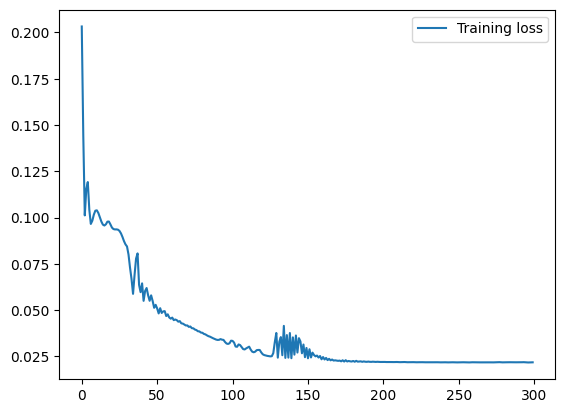

In [86]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [87]:
np.mean((y_train_pred.detach().numpy()-y_train.detach().numpy()) ** 2)

0.0014600597

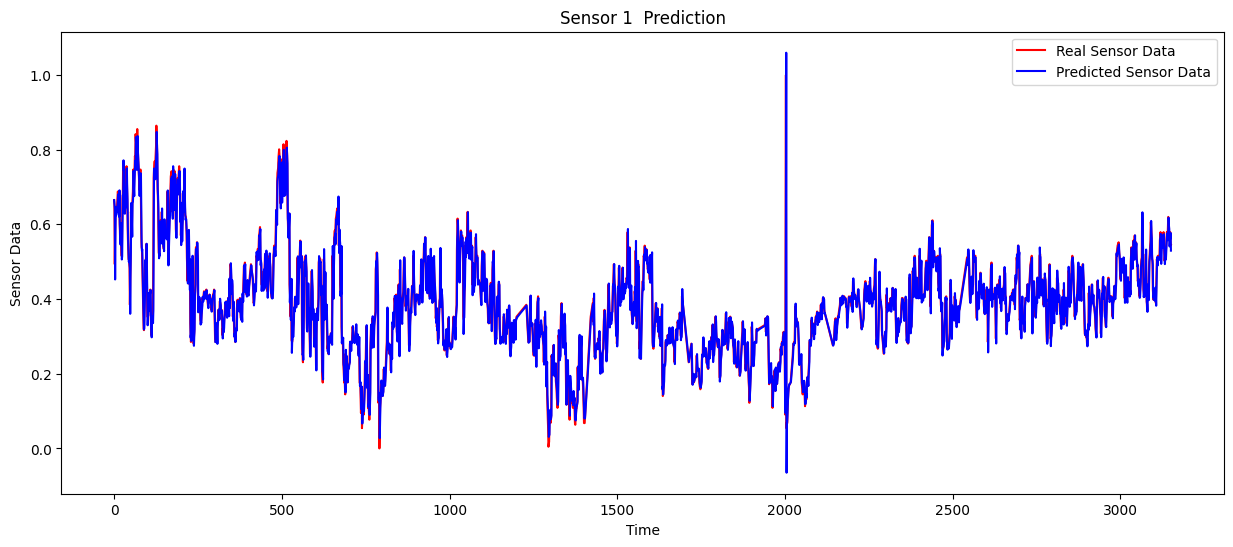

In [88]:
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot( y_train.detach().numpy(), color = 'red', label = 'Real Sensor Data')
axes.plot( y_train_pred.detach().numpy(), color = 'blue', label = 'Predicted Sensor Data')
plt.title('Sensor Prediction')
plt.xlabel('Time')
plt.ylabel('Sensor Data')
plt.legend()
plt.show()

In [89]:
# %%
# make predictions
y_test_pred = model(x_test)

# # Implement transform
# # invert predictions
y_train_pred = (y_train_pred.detach().numpy())
y_train = (y_train.detach().numpy())
y_test_pred = (y_test_pred.detach().numpy())
y_test = (y_test.detach().numpy())


# invert predictions
y_train_pred = invMinMax(y_train_pred, leak_data['Sensor 1'])
y_train = invMinMax(y_train, leak_data['Sensor 1'])
y_test_pred = invMinMax(y_test_pred, leak_data['Sensor 1'])
y_test = invMinMax(y_test, leak_data['Sensor 1'])


y_test_pred = y_test_pred
print(type(y_train))



# calculate  mean absolute error
print(y_train[:,0], y_train_pred[:,0])
trainScore = (mean_absolute_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f MAE' % (trainScore))
testScore =(mean_absolute_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAE' % (testScore))


<class 'numpy.ndarray'>
[1002.   999.   964.  ...  983.   975.   975.5] [1001.91144  999.59753  996.74194 ...  979.2573   982.51373  972.0379 ]
Train Score: 4.83 MAE
Test Score: 4.17 MAE


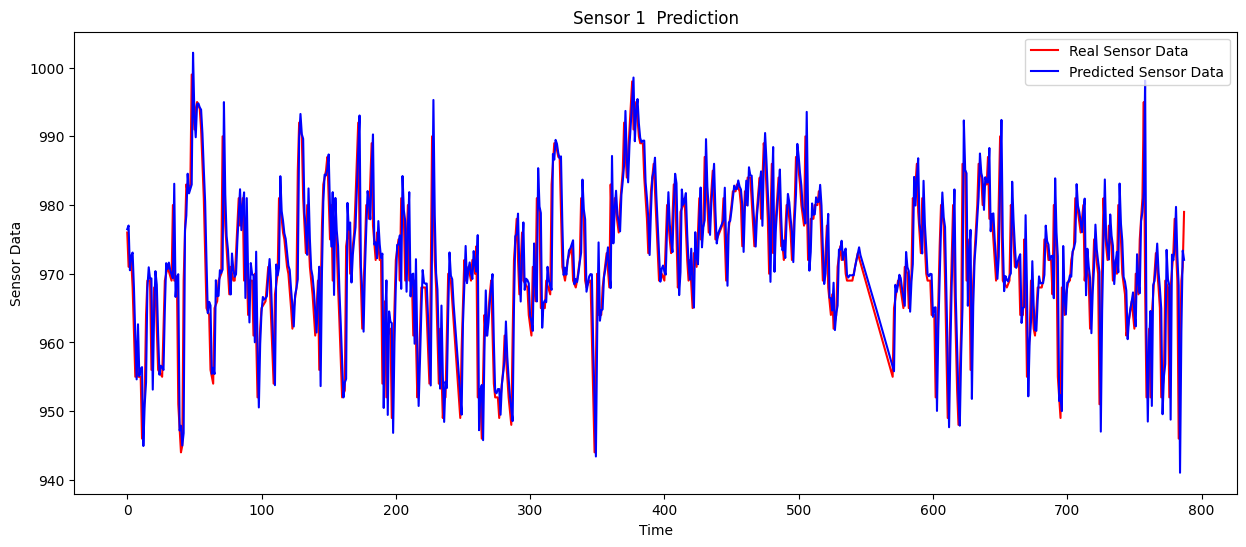

In [90]:
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot( y_test, color = 'red', label = 'Real Sensor Data')
axes.plot( y_test_pred, color = 'blue', label = 'Predicted Sensor Data')
plt.title('Sensor Prediction')
plt.xlabel('Time')
plt.ylabel('Sensor Data')
plt.legend()
plt.show()

In [97]:
def get_prediction(startIndex, indexes_after):
    current = leak_data[['Normalized Sensor 1']].iloc[startIndex-look_back : startIndex].to_numpy()
    current = torch.tensor(current, dtype=torch.float32)
    current = current.reshape(1, len(current), 1)

    predictions = []
    for _ in range(indexes_after):
        pred = model(current).detach()
        predictions.append(pred.squeeze().item())
        current = torch.cat((current[:, 1:, :], pred.unsqueeze(1)), dim=1)

    predictions = invMinMax(torch.tensor(predictions), leak_data['Sensor 1'])
    return predictions.tolist()

get_prediction(60,10)
startTime = 60
leak_data[['Normalized Sensor 1']].iloc[startTime-look_back : startTime].to_numpy()

array([[0.71455505],
       [0.71719457],
       [0.71983409],
       [0.7224736 ],
       [0.72511312],
       [0.72775264],
       [0.73039216],
       [0.73303167],
       [0.74660633],
       [0.86425339],
       [0.87330317],
       [0.88235294],
       [0.86425339],
       [0.80769231],
       [0.75113122],
       [0.7239819 ],
       [0.70135747],
       [0.67873303],
       [0.67873303],
       [0.74208145],
       [0.74434389],
       [0.74660633],
       [0.74208145],
       [0.74886878],
       [0.75565611],
       [0.74208145],
       [0.77375566],
       [0.80542986],
       [0.75565611],
       [0.66515837],
       [0.69457014],
       [0.7239819 ],
       [0.74208145],
       [0.7498384 ],
       [0.75759535],
       [0.76535229],
       [0.77310924],
       [0.78086619],
       [0.78862314],
       [0.79638009],
       [0.80995475],
       [0.80316742],
       [0.79638009],
       [0.78129713],
       [0.76621418],
       [0.75113122],
       [0.74095023],
       [0.730